In [26]:
# helpers for policy network
import haiku as hk
import jax.numpy as jnp
import numpy as np
import random
import pandas as pd

def base_network(x, layers):
  x = hk.nets.MLP(layers[:-1], activate_final=True)(x)
  x = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(x)
  x = hk.Linear(layers[-1])(x)
  x = jax.nn.relu(x)
  x = hk.Linear(num_actions)(x)
  return x

def adv_network(x, mask):
  x = base_network(x, advantage_network_layers)
  x = mask * x
  return x

def policy_network(x, mask):
  x = base_network(x, policy_network_layers)
  x = jnp.where(mask == 1, x, -10e20)
  x = jax.nn.softmax(x)
  return x

In [27]:
from our_method import hexner_full_fix_3_test, hexner_full_fix_4_test
import pyspiel
from open_spiel.python import policy
import jax
from flax.training import checkpoints

In [28]:
## |A| = 9

# game = pyspiel.load_game_as_turn_based("python_hexner_full_test")
initial_state = [-0.5, 0, 0., 0., 0.5, 0, 0., 0.]
game = pyspiel.convert_to_turn_based(hexner_full_fix_3_test.HexnerGame(initial_state=initial_state))
policy_network_params = checkpoints.restore_checkpoint('cfr_policy_3/checkpoint_1000/checkpoint', target=None)
num_actions = game.num_distinct_actions()
root_node = game.new_initial_state()
embedding_size = len(root_node.information_state_tensor(0))
policy_network_layers = (256, 256)

policy_net = hk.without_apply_rng(hk.transform(policy_network))
rng_key = jax.random.PRNGKey(42)
x, mask = (jnp.ones([1, embedding_size]),
           jnp.ones([1, num_actions]))
# init network
_ = policy_net.init(rng_key, x, mask)

In [29]:
ys = [-0.5, -0.25, 0.25, 0.5]
for run in range(len(ys)):
    initial_state = [-0.5, ys[run], 0., 0., 0.5, ys[run], 0., 0.]
    game = pyspiel.convert_to_turn_based(hexner_full_fix_3_test.HexnerGame(initial_state=initial_state))
    state = game.new_initial_state()
    game_states = [state.information_state_tensor(0)[6:6+8]]
    p1_actions = []
    p2_actions = []
    
    while not state.is_terminal():
        # store the states 
        if state.current_player() == 0:
            game_states.append(state.information_state_tensor(0)[6:6+8])
                              
        legal_actions = state.legal_actions()
        if state.is_chance_node():
            # outcomes_with_probs = state.chance_outcomes()
            # action_list, prob_list = zip(*outcomes_with_probs)
            # action = np.random.choice(action_list, p=prob_list)
            # manually select type
            action = 0
            state.apply_action(action)
            if action == 0:
                target = 2  # if [1, 0] goal is 2 (right) else 1
            else:
                target = 1
        else:
            cur_player = state.current_player()
            legal_actions = state.legal_actions(cur_player)
            info_state_vector = jnp.array(
                                state.information_state_tensor(cur_player), dtype=jnp.float32)
            legal_actions_mask = jnp.array(
                                state.legal_actions_mask(cur_player), dtype=jnp.float32)
            probs = policy_net.apply(policy_network_params,
                                              info_state_vector, legal_actions_mask)
            # normalize again for numerical soundness
            probs = probs/probs.sum()
            action = random.choices(legal_actions, probs)[0]
            if state.current_player() == 0:
                p1_actions.append(action)
            else:
                p2_actions.append(action)
            state.apply_action(action)

    
    game_states = jnp.vstack(game_states)
    x1 = game_states[:, 0]
    y1 = game_states[:, 1]
    
    x2 = game_states[:, 4]
    y2 = game_states[:, 5]
    df = pd.DataFrame({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

    df.to_csv(f'deepcfr_trajs_type_{target}_{run}.csv')

/var/folders/xd/5m8xqhxj7nb98dkg_t5fs5zc0000gq/T/ipykernel_35905/1504887392.py:46: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  game_states = jnp.vstack(game_states)


In [30]:
## |A| = 16

# game = pyspiel.load_game_as_turn_based("python_hexner_full_test")
initial_state = [-0.5, 0., 0., 0., 0.5, 0., 0., 0.]
game = pyspiel.convert_to_turn_based(hexner_full_fix_4_test.HexnerGame(initial_state=initial_state))
policy_network_params = checkpoints.restore_checkpoint('cfr_policy_4/checkpoint_100/checkpoint', target=None)
num_actions = game.num_distinct_actions()
root_node = game.new_initial_state()
embedding_size = len(root_node.information_state_tensor(0))
policy_network_layers = (256, 256)

policy_net = hk.without_apply_rng(hk.transform(policy_network))
rng_key = jax.random.PRNGKey(42)
x, mask = (jnp.ones([1, embedding_size]),
           jnp.ones([1, num_actions]))
# init network
_ = policy_net.init(rng_key, x, mask)

In [31]:
ys = [-0.5, -0.25, 0.25, 0.5]
for run in range(len(ys)):
    initial_state = [-0.5, ys[run], 0., 0., 0.5, ys[run], 0., 0.]
    game = pyspiel.convert_to_turn_based(hexner_full_fix_4_test.HexnerGame(initial_state=initial_state))
    state = game.new_initial_state()
    game_states = [state.information_state_tensor(0)[6:6+8]]
    p1_actions = []
    p2_actions = []
    
    while not state.is_terminal():
        # store the states 
        if state.current_player() == 0:
            game_states.append(state.information_state_tensor(0)[6:6+8])
                              
        legal_actions = state.legal_actions()
        if state.is_chance_node():
            # outcomes_with_probs = state.chance_outcomes()
            # action_list, prob_list = zip(*outcomes_with_probs)
            # action = np.random.choice(action_list, p=prob_list)
            # manually select type
            action = 0
            state.apply_action(action)
            if action == 0:
                target = 2  # if [1, 0] goal is 2 (right) else 1
            else:
                target = 1
        else:
            cur_player = state.current_player()
            legal_actions = state.legal_actions(cur_player)
            info_state_vector = jnp.array(
                                state.information_state_tensor(cur_player), dtype=jnp.float32)
            legal_actions_mask = jnp.array(
                                state.legal_actions_mask(cur_player), dtype=jnp.float32)
            probs = policy_net.apply(policy_network_params,
                                              info_state_vector, legal_actions_mask)
            # normalize again for numerical soundness
            probs = probs/probs.sum()
            action = random.choices(legal_actions, probs)[0]
            if state.current_player() == 0:
                p1_actions.append(action)
            else:
                p2_actions.append(action)
            state.apply_action(action)

    
    game_states = jnp.vstack(game_states)
    x1 = game_states[:, 0]
    y1 = game_states[:, 1]
    
    x2 = game_states[:, 4]
    y2 = game_states[:, 5]
    df = pd.DataFrame({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

    df.to_csv(f'deepcfr_trajs_16_type_{target}_{run}.csv')

/var/folders/xd/5m8xqhxj7nb98dkg_t5fs5zc0000gq/T/ipykernel_35905/3724137218.py:46: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  game_states = jnp.vstack(game_states)


In [23]:
state = game.new_initial_state()
game_states = [state.information_state_tensor(0)[6:6+8]]
p1_actions = []
p2_actions = []

while not state.is_terminal():
    # store the states 
    if state.current_player() == 0:
        game_states.append(state.information_state_tensor(0)[6:6+8])
                          
    legal_actions = state.legal_actions()
    if state.is_chance_node():
        # outcomes_with_probs = state.chance_outcomes()
        # action_list, prob_list = zip(*outcomes_with_probs)
        # action = np.random.choice(action_list, p=prob_list)
        # manually select type
        action = 1
        state.apply_action(action)
        if action == 0:
            target = 2  # if [1, 0] goal is 2 (right) else 1
        else:
            target = 1
    else:
        cur_player = state.current_player()
        legal_actions = state.legal_actions(cur_player)
        info_state_vector = jnp.array(
                            state.information_state_tensor(cur_player), dtype=jnp.float32)
        legal_actions_mask = jnp.array(
                            state.legal_actions_mask(cur_player), dtype=jnp.float32)
        probs = policy_net.apply(policy_network_params,
                                          info_state_vector, legal_actions_mask)
        # normalize again for numerical soundness
        probs = probs/probs.sum()
        action = random.choices(legal_actions, probs)[0]
        if state.current_player() == 0:
            p1_actions.append(action)
        else:
            p2_actions.append(action)
        state.apply_action(action)

/var/folders/xd/5m8xqhxj7nb98dkg_t5fs5zc0000gq/T/ipykernel_35905/2070213082.py:3: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  game_states = jnp.vstack(game_states)


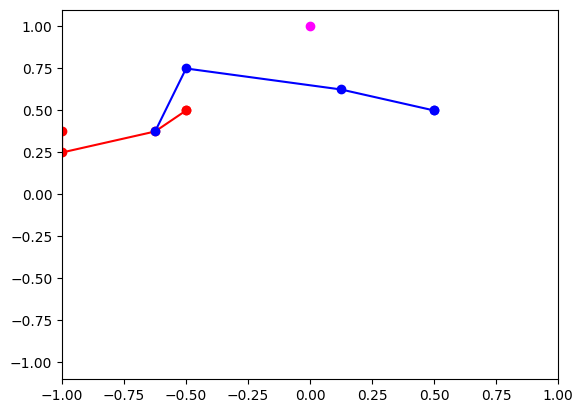

In [24]:
import matplotlib.pyplot as plt

game_states = jnp.vstack(game_states)
x1 = game_states[:, 0]
y1 = game_states[:, 1]

x2 = game_states[:, 4]
y2 = game_states[:, 5]

plt.plot(x1, y1, color='red', marker='o')
plt.plot(x2, y2, marker='o', color='blue')
plt.xlim([-1, 1])
plt.ylim([-1.1, 1.1])
if target == 2:
    plt.scatter(0, -1, color='magenta')
else:
    plt.scatter(0, 1, color='magenta')

df = pd.DataFrame({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

df.to_csv(f'deepcfr_trajs_type_{target}.csv')

In [25]:
## repeat for |A|=16
game = pyspiel.load_game_as_turn_based("python_hexner_full_4_test")
policy_network_params = checkpoints.restore_checkpoint('cfr_policy_4/checkpoint_100/checkpoint', target=None)


num_actions = game.num_distinct_actions()
root_node = game.new_initial_state()
embedding_size = len(root_node.information_state_tensor(0))
policy_network_layers = (256, 256)

policy_net = hk.without_apply_rng(hk.transform(policy_network))
rng_key = jax.random.PRNGKey(42)
x, mask = (jnp.ones([1, embedding_size]),
           jnp.ones([1, num_actions]))
# init network
_ = policy_net.init(rng_key, x, mask)


TypeError: float() argument must be a string or a number, not 'dict'

In [124]:
state = game.new_initial_state()
game_states = [state.information_state_tensor(0)[6:6+8]]
p1_actions = []
p2_actions = []

while not state.is_terminal():
    # store the states 
    if state.current_player() == 0:
        game_states.append(state.information_state_tensor(0)[6:6+8])
                          
    legal_actions = state.legal_actions()
    if state.is_chance_node():
        # outcomes_with_probs = state.chance_outcomes()
        # action_list, prob_list = zip(*outcomes_with_probs)
        # action = np.random.choice(action_list, p=prob_list)
        action = 1
        state.apply_action(action)
        if action == 0:
            target = 2  # if [1, 0] goal is 2 (right) else 1
        else:
            target = 1
    else:
        cur_player = state.current_player()
        legal_actions = state.legal_actions(cur_player)
        info_state_vector = jnp.array(
                            state.information_state_tensor(cur_player), dtype=jnp.float32)
        legal_actions_mask = jnp.array(
                            state.legal_actions_mask(cur_player), dtype=jnp.float32)
        probs = policy_net.apply(policy_network_params,
                                          info_state_vector, legal_actions_mask)
        # normalize again for numerical soundness
        probs = probs/probs.sum()
        action = random.choices(legal_actions, probs)[0]
        if state.current_player() == 0:
            p1_actions.append(action)
        else:
            p2_actions.append(action)
        state.apply_action(action)

/var/folders/xd/5m8xqhxj7nb98dkg_t5fs5zc0000gq/T/ipykernel_46614/1177110427.py:3: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  game_states = jnp.vstack(game_states)


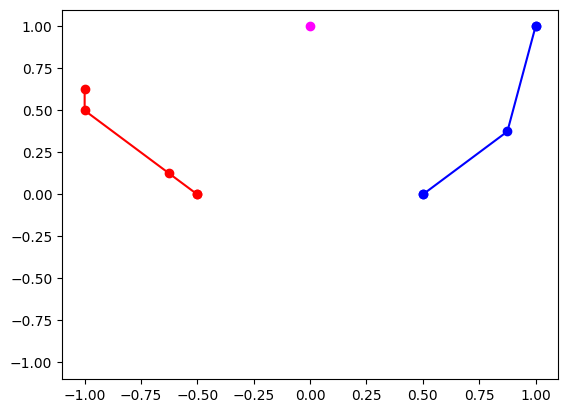

In [125]:
import matplotlib.pyplot as plt

game_states = jnp.vstack(game_states)
x1 = game_states[:, 0]
y1 = game_states[:, 1]

x2 = game_states[:, 4]
y2 = game_states[:, 5]

plt.plot(x1, y1, color='red', marker='o')
plt.plot(x2, y2, marker='o', color='blue')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
if target == 2:
    plt.scatter(0, -1, color='magenta')
else:
    plt.scatter(0, 1, color='magenta')

df = pd.DataFrame({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

df.to_csv(f'deepcfr_trajs_16_type_{target}.csv')